# Week 8 practical -  learning : Maximum likelihood estimate

In [9]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# Re-seed for reproducibility
np.random.seed(42)


## 3B)

In [20]:

def generate_hamming_data(M, theta_e, theta_b4, theta_b5, theta_b6):
    """
    Generate M i.i.d. data points for the Hamming (7,4) model:
    - Data bits b0..b3 ~ Bernoulli(0.5)
    - Check bits b4|b0,b1,b2, b5|b0,b2,b3, b6|b0,b1,b3  according to provided conditional tables
    - Received bits ri|bi flip with probability theta_e
    """
    records = []
    for _ in range(M):

        # Sample data bits -  generated uniformly
        b = np.random.binomial(1, 0.5, size=4)
        b0, b1, b2, b3 = b
        
        # 2) draw check bits probabilistically
        b4 = np.random.binomial(1, theta_b4[(b0, b1, b2)])
        b5 = np.random.binomial(1, theta_b5[(b0, b2, b3)])
        b6 = np.random.binomial(1, theta_b6[(b0, b1, b3)])

        b_all = np.array([b0, b1, b2, b3, b4, b5, b6]) # true bits
        
        # Sample received bits with flip probability theta_e
        flips = np.random.rand(7) < theta_e
        r_all = np.where(flips, 1 - b_all, b_all)
        
        # Record one data point
        rec = {f"b{i}": int(b_all[i]) for i in range(7)}
        rec.update({f"r{i}": int(r_all[i]) for i in range(7)})
        records.append(rec)
    
    return pd.DataFrame(records)

# Choose actual parameter values
theta_e = 0.3  # flip probability

# For each (b0,b1,b2), specify P(b4=1 | b0,b1,b2) / p(b4=0 | b0, b1, b2)
theta_b4 = {
    (0,0,0): 0.8,
    (0,0,1): 0.1,
    (0,1,0): 0.5,
    (0,1,1): 0.2,
    (1,0,0): 0.9,
    (1,0,1): 0.3,
    (1,1,0): 0.4,
    (1,1,1): 0.6,
}

# Similarly for b5, which depends on (b0,b2,b3):
theta_b5 = {
    (0,0,0): 0.8,
    (0,0,1): 0.1,
    (0,1,0): 0.5,
    (0,1,1): 0.2,
    (1,0,0): 0.9,
    (1,0,1): 0.3,
    (1,1,0): 0.4,
    (1,1,1): 0.6,
}

# And for b6 depending on (b0,b1,b3):
theta_b6 = {
    (0,0,0): 0.8,
    (0,0,1): 0.1,
    (0,1,0): 0.5,
    (0,1,1): 0.2,
    (1,0,0): 0.9,
    (1,0,1): 0.3,
    (1,1,0): 0.4,
    (1,1,1): 0.6,
}


# Generate M samples
M = 1000
D = generate_hamming_data(M, theta_e, theta_b4, theta_b5, theta_b6)

# Display the first few rows
print(D.head(20))


    b0  b1  b2  b3  b4  b5  b6  r0  r1  r2  r3  r4  r5  r6
0    0   0   0   1   1   0   0   1   1   0   1   1   1   0
1    1   0   1   0   0   1   0   1   0   0   0   0   0   0
2    0   1   0   1   0   0   0   1   1   0   1   0   0   0
3    0   0   0   0   1   1   0   0   1   0   1   1   0   0
4    1   0   0   1   1   1   1   0   0   1   1   1   1   0
5    0   0   1   1   0   0   0   0   0   1   1   0   0   0
6    0   0   0   1   1   0   1   1   0   0   0   0   1   0
7    1   1   1   1   0   1   0   1   1   1   1   1   0   0
8    1   1   0   1   0   0   1   1   1   0   1   0   0   1
9    1   0   0   0   1   1   1   1   1   1   0   0   0   1
10   1   0   1   1   0   0   0   1   0   1   0   0   0   1
11   0   1   1   0   0   0   1   1   1   1   0   1   0   0
12   1   1   0   1   1   0   1   0   0   0   1   1   0   1
13   1   1   1   1   0   1   1   1   1   0   0   0   0   0
14   1   1   1   0   0   0   0   1   1   1   0   0   1   0
15   0   0   1   0   0   1   1   0   0   1   1   0   0  

## 3E)

In [21]:
# sampled datapoints - D is the DataFrame with columns b0…b6 and r0…r6

print(D.head())

# MLE for theta_e (flip probabibility)
M = len(D)
total_bits = 7 * M

# Count mismatches (r != b) across all i=0…6
mismatches = sum((D[f"b{i}"] != D[f"r{i}"]).sum() for i in range(7))

# MLE estimate
theta_e_hat = mismatches / total_bits

print(f"MLE θ_e = {theta_e_hat:.4f}")

# Compute MLE estimates
theta_b4_hat = {}
theta_b5_hat = {}
theta_b6_hat = {}
for combo in itertools.product([0,1], repeat=3):
    cond4 = (D['b0']==combo[0]) & (D['b1']==combo[1]) & (D['b2']==combo[2])
    theta_b4_hat[combo] = ((D['b4']==1)&cond4).sum() / cond4.sum()
    
    cond5 = (D['b0']==combo[0]) & (D['b2']==combo[1]) & (D['b3']==combo[2])
    theta_b5_hat[combo] = ((D['b5']==1)&cond5).sum() / cond5.sum()
    
    cond6 = (D['b0']==combo[0]) & (D['b1']==combo[1]) & (D['b3']==combo[2])
    theta_b6_hat[combo] = ((D['b6']==1)&cond6).sum() / cond6.sum()

# Build DataFrames
df4 = pd.DataFrame([{'b0':k[0],'b1':k[1],'b2':k[2],'theta_b4_hat':v} for k,v in theta_b4_hat.items()])
df5 = pd.DataFrame([{'b0':k[0],'b2':k[1],'b3':k[2],'theta_b5_hat':v} for k,v in theta_b5_hat.items()])
df6 = pd.DataFrame([{'b0':k[0],'b1':k[1],'b3':k[2],'theta_b6_hat':v} for k,v in theta_b6_hat.items()])

# Display each MLE table
print("Parity bit 4 conditional table:\n: ",df4)
print("Parity bit 5 conditional table:\n: ",df5)
print("Parity bit 6 conditional table:\n: ",df6)



   b0  b1  b2  b3  b4  b5  b6  r0  r1  r2  r3  r4  r5  r6
0   0   0   0   1   1   0   0   1   1   0   1   1   1   0
1   1   0   1   0   0   1   0   1   0   0   0   0   0   0
2   0   1   0   1   0   0   0   1   1   0   1   0   0   0
3   0   0   0   0   1   1   0   0   1   0   1   1   0   0
4   1   0   0   1   1   1   1   0   0   1   1   1   1   0
MLE θ_e = 0.3086
Parity bit 4 conditional table:
:     b0  b1  b2  theta_b4_hat
0   0   0   0      0.773109
1   0   0   1      0.107438
2   0   1   0      0.503704
3   0   1   1      0.176923
4   1   0   0      0.867769
5   1   0   1      0.266129
6   1   1   0      0.408696
7   1   1   1      0.540741
Parity bit 5 conditional table:
:     b0  b2  b3  theta_b5_hat
0   0   0   0      0.773913
1   0   0   1      0.079137
2   0   1   0      0.518519
3   0   1   1      0.224138
4   1   0   0      0.893443
5   1   0   1      0.307018
6   1   1   0      0.382550
7   1   1   1      0.600000
Parity bit 6 conditional table:
:     b0  b1  b3  theta_b6_ha

## 3F)

### i) effect of number of data points on accuracy of parameter estimates
- a lager number of data points results in an improvement in the accuracy, the inverse is true as well. For fewer data points the accuracy of parameter estimates decreases

### ii) conditions not able estimate certain parameters
- The condition under which certain parameters are not estimable may be if there is too few data points.There are 8 possible parameters settings for each checkbit table and at least one example of each is needed to estimate all 8 parameters. If M<8 some parameter combinations might be missing. And also it's still possible that even if M>8 but not large enough it might happen that some combinations may still not occur.

# 4: Practical: MLE for a simple regression example

## 4d)

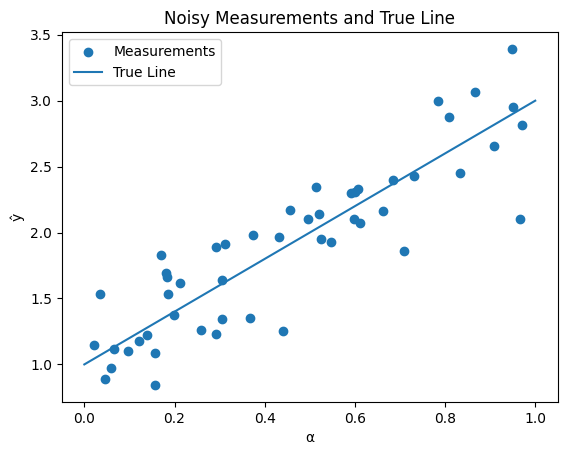

In [30]:

# Parameters for the true line and measurement noise
yI = 1.0      # y-coordinate at α=0
yF = 3.0      # y-coordinate at α=1
sigma_v2 = 0.1
sigma_v = np.sqrt(sigma_v2)

# Number of measurements
M = 50

np.random.seed(42)         # Set the seed for reproducibility
# Sample α uniformly from [0,1]
alpha = np.random.rand(M)

# Generate noisy measurements y_hat according to Equation (4)
y_hat = (1 - alpha) * yI + alpha * yF + np.random.randn(M) * sigma_v

# Plot measurements and the true line
plt.figure()
plt.scatter(alpha, y_hat, label='Measurements')
alpha_line = np.linspace(0, 1, 200)
y_line = (1 - alpha_line) * yI + alpha_line * yF
plt.plot(alpha_line, y_line, label='True Line')
plt.xlabel('α')
plt.ylabel('ŷ')
plt.title('Noisy Measurements and True Line')
plt.legend()
plt.show()


## 4e)

Estimated yI: 
 1.0215096157546755

Estimated yF: 
 2.9755322930423707
Close to the true value of the estimate


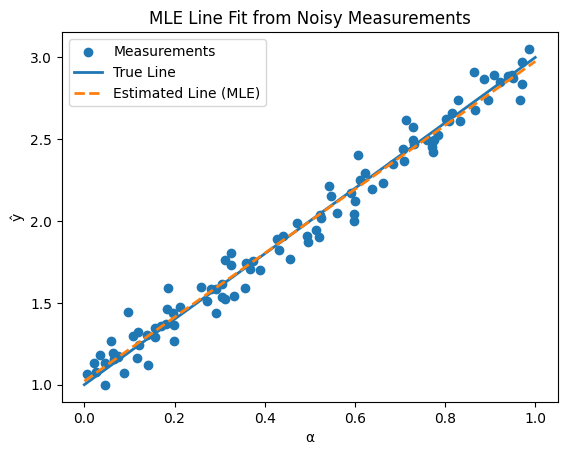

"Very, Very Interesting: I'm impressed by the fit of the line whose paremeters (yI, yF) \nwere calculated using  MLE\n"

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# True parameters
yI_true = 1.0
yF_true = 3.0
sigma_v2 = 0.1
sigma_v = np.sqrt(sigma_v2)
M = 100

# Generate α and noisy measurements
alpha = np.random.rand(M)
y_hat = (1 - alpha) * yI_true + alpha * yF_true + np.random.randn(M) * sigma_v

# Compute MLE using the matrix equation froom 4c
A = np.vstack([
    np.vstack([(1 - alpha) ** 2, alpha * (1 - alpha)]),
    np.vstack([alpha * (1 - alpha), alpha ** 2])
]).reshape(2, 2, -1).sum(axis=2)  # 2x2 matrix

b = np.array([
    np.sum((1 - alpha) * y_hat),
    np.sum(alpha * y_hat)
])  # 2x1 vector

# Solve for [yI_ML, yF_ML]
theta_ml = np.linalg.solve(A, b)
yI_ml, yF_ml = theta_ml

print("Estimated yI: \n", yI_ml)
print("\nEstimated yF: \n", yF_ml)

print("Close to the true value of the estimate")

# Plot everything
alpha_line = np.linspace(0, 1, 200)
y_true_line = (1 - alpha_line) * yI_true + alpha_line * yF_true
y_est_line = (1 - alpha_line) * yI_ml + alpha_line * yF_ml

plt.figure()
plt.scatter(alpha, y_hat, label='Measurements')
plt.plot(alpha_line, y_true_line, label='True Line', linewidth=2)
plt.plot(alpha_line, y_est_line, label='Estimated Line (MLE)', linestyle='--', linewidth=2)
plt.xlabel('α')
plt.ylabel('ŷ')
plt.title('MLE Line Fit from Noisy Measurements')
plt.legend()
plt.show()


'''Very, Very Interesting: I'm impressed by the fit of the line whose paremeters (yI, yF) 
were calculated using  MLE
'''

## 4F)
### i) effect of number of measurements on the accuracy of the line fit
- fewer number of data points, results in poor line fit. The inverse is true for more lines fit.

### ii) lowest number of measure that can be used to fit a line
- 2 is the lowest number of measurements that that can be used to fit a line, which corresponds to the number of parameters.

## 4G)  vary covariance of noise, keep M fixed
### i) measurement noise influence on parameter estimation
- yes it influence the parameter estimation calculation where for large values of 